In [1]:
import os
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from PIL import Image
from glob import glob
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def set_seed(seed_value=42):
    """Set seed for reproducibility."""
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)

    # If you are using GPU
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)

## Project configuration

In [3]:
config = {
    'ROOT_DIR': '/kaggle/input/state-farm-distracted-driver-detection/imgs/train',
    'TEST_DIR': '/kaggle/input/state-farm-distracted-driver-detection/imgs/test',
    'MODELS_DIR': '/kaggle/working/',
    'IMG_SIZE': 224,
    'BATCH_SIZE': 64,
    'EPOCHS': 100,
    'PATIENCE': 9,
    'WARMUP_EPOCHS': 5,
    'LR_INIT': 1e-4,
    'WEIGHT_DECAY': 3e-4,
    'NUM_CLASSES': 10,
    'NUM_WORKERS': 4,
    'NUM_CHANNELS': 3,
    'DEVICE': torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'),
}

## Utility functions and variables

In [4]:
# train transformations
train_transforms = transforms.Compose([
    transforms.Resize((config['IMG_SIZE'], config['IMG_SIZE'])),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=(-30, 30)),
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225]),
])

# val/test/inference transformations
val_transforms = transforms.Compose([
    transforms.Resize((config['IMG_SIZE'], config['IMG_SIZE'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225]),
])

# read the directory and get all images and their corresponding labels
def get_images_labels():
    images = []
    labels = []

    for label in list(glob(os.path.join(config['ROOT_DIR'], '*'))):
        imgs_paths = list(glob(os.path.join(config['ROOT_DIR'], label, '*.jpg')))
        labels.extend([int(label[-1]) for i in range(len(imgs_paths))])
        images.extend([image for image in imgs_paths])
    
    return images, labels

# custom Dataset class
class CNNCustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        super().__init__()
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        # getting the path to one image
        img_path = self.images[index]

        image = Image.open(img_path).convert('RGB')
        label = self.labels[index]

        if self.transform:
            image = self.transform(image)

        return image, label

In [5]:
# to get DataLoaders from custom Dataset
def get_dataloaders():
    train_transformations = train_transforms
    val_transformations = val_transforms

    all_images, all_labels = get_images_labels()
    train_images, val_images, train_labels, val_labels = train_test_split(all_images,
                                                                          all_labels,
                                                                          test_size=0.2,
                                                                          random_state=42)
    
    train_dataset = CNNCustomDataset(train_images, train_labels, transform=train_transformations)
    val_dataset = CNNCustomDataset(val_images, val_labels, transform=val_transformations)

    train_loader = DataLoader(train_dataset, batch_size=config['BATCH_SIZE'], shuffle=True, num_workers=config['NUM_WORKERS'])
    val_loader = DataLoader(val_dataset, batch_size=config['BATCH_SIZE'], shuffle=False, num_workers=config['NUM_WORKERS'])

    return train_loader, val_loader

In [6]:
# cosine annealing adjusting learning rate
def adjust_learning_rate(optimizer, epoch, warmup=True, warmup_ep=config['WARMUP_EPOCHS'], enable_cos=True):
    lr = config['LR_INIT']
    if warmup and epoch < warmup_ep:
        lr = lr / (warmup_ep - epoch)
    elif enable_cos:
        lr *= 0.5 * (1. + math.cos(math.pi * (epoch - warmup_ep) / (config['EPOCHS'] - warmup_ep)))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [7]:
# in order to evaluate the model on metrics such as accuracy and f1
def get_metrics(labels, preds):
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')
    return accuracy, precision, recall, f1

In [8]:
# plot training process in graphs
def save_graphs(train, val, graph_type='None'):
    plt.figure(figsize=(10,5))
    plt.title(f"Training and Validation {graph_type}")
    plt.plot(val, label="validation")
    plt.plot(train, label="train")
    plt.xlabel("Epoch")
    plt.ylabel(graph_type)
    plt.legend()
    plt.savefig(f'{graph_type}.png')

In [9]:
def train(train_loader, model, loss_fn, optimizer, epoch, device):
    model.train()

    # will be used to calculate metrics
    predictions = []
    all_labels = []
    total_loss = 0.0

    for data in tqdm(train_loader, desc='Training'):
        imgs, labels = data
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        logits = model(imgs)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()

        # get predictions as the index of max logit
        preds = torch.argmax(logits, dim=1)
        predictions.extend(preds.detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())
        total_loss += loss.item()
    
    # get metrics
    accuracy, precision, recall, f1 = get_metrics(all_labels, predictions)
    avg_loss = total_loss / len(train_loader)

    print(f'Epoch {epoch} | Train Loss: {avg_loss} | Accuracy: {accuracy} | Precision: {precision} | Recall: {recall} | F1: {f1}')
    return avg_loss, accuracy, precision, recall, f1

In [10]:
def evaluate(val_loader, model, loss_fn, device):
    model.eval()

    # will be used to calculate metrics
    predictions = []
    all_labels = []
    total_loss = 0.0

    for data in tqdm(val_loader, desc='Validating'):
        imgs, labels = data
        imgs, labels = imgs.to(device), labels.to(device)

        with torch.no_grad():
            logits = model(imgs)
            loss = loss_fn(logits, labels)

        # get predictions as the index of max logit
        preds = torch.argmax(logits, dim=1)
        predictions.extend(preds.detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())
        total_loss += loss.item()
    
    # get metrics
    accuracy, precision, recall, f1 = get_metrics(all_labels, predictions)
    avg_loss = total_loss / len(val_loader)

    print(f'\tValidation Loss: {avg_loss} | Accuracy: {accuracy} | Precision: {precision} | Recall: {recall} | F1: {f1}')
    return avg_loss, accuracy, precision, recall, f1

In [11]:
def run_training(train_loader, val_loader, model, model_name, loss_fn, optimizer, config):
    TRAIN_HISTORY = {
        'Loss': [],
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1': []
    }
    VAL_HISTORY = {
        'Loss': [],
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1': []
    }

    # for early stopping
    # we will save the best model based on the validation loss
    best_loss = np.inf  # set to infinity so that the first validation loss is always lower
    patience_counter = 0

    for epoch in range(config['EPOCHS']):
        adjust_learning_rate(optimizer=optimizer, epoch=epoch)
        loss, accuracy, precision, recall, f1 = train(train_loader, model, loss_fn, optimizer, epoch + 1, config['DEVICE'])
        TRAIN_HISTORY['Loss'].append(loss)
        TRAIN_HISTORY['Accuracy'].append(accuracy)
        TRAIN_HISTORY['Precision'].append(precision)
        TRAIN_HISTORY['Recall'].append(recall)
        TRAIN_HISTORY['F1'].append(f1)

        loss, accuracy, precision, recall, f1 = evaluate(val_loader, model, loss_fn, config['DEVICE'])
        VAL_HISTORY['Loss'].append(loss)
        VAL_HISTORY['Accuracy'].append(accuracy)
        VAL_HISTORY['Precision'].append(precision)
        VAL_HISTORY['Recall'].append(recall)
        VAL_HISTORY['F1'].append(f1)

        # since our evaluation metric is logloss, we want to minimize it and early stopping will be based on it
        if loss < best_loss:
            best_loss = loss
            patience_counter = 0
            print(f'Saving best model at epoch {epoch + 1}...')
            torch.save(model.state_dict(), f'{model_name}_best_model.pth')
        else:
            patience_counter += 1
            if patience_counter == config['PATIENCE']:
                print(f"Early stopping at epoch {epoch + 1}")
                break
        
    save_graphs(TRAIN_HISTORY['Loss'], VAL_HISTORY['Loss'], graph_type='Loss')
    save_graphs(TRAIN_HISTORY['Accuracy'], VAL_HISTORY['Accuracy'], graph_type='Accuracy')
    save_graphs(TRAIN_HISTORY['F1'], VAL_HISTORY['F1'], graph_type='F1')
    
    print('Training finished!')
    return TRAIN_HISTORY, VAL_HISTORY

## Our implementation of ResNet50 and ResNet101

In [12]:
# Block for ResNet50 and ResNet101 architectures
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        """
        :param in_channels: number of input channels
        :param out_channels: number of output channels
        :param identity_downsample: Conv layer to downsample image in case of different input and output channels
        :param stride: stride
        """
        super().__init__()
        self.identity_downsample = identity_downsample

        # every block in ResNet50 or deeper increases the number of in_channels by 4
        self.expansion = 4
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(out_channels * self.expansion),
            nn.ReLU()
        )
    
    def forward(self, x):
        identity = x

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        # if the input and output channels are different, then downsample (with no activation, hence identity) the input image
        if self.identity_downsample:
            identity = self.identity_downsample(identity)
        
        # add the identity (input image) to the output of the block
        x = x + identity
        x = F.relu(x)
        return x

# ResNet50 and ResNet101 architectures
class MyResNet(nn.Module):
    def __init__(self, num_layers, in_channels, out_classes):
        """
        :param num_layers: number of layers in the architecture (ResNet)
        :param in_channels: number of input image channels
        :param out_classes: number of output classes
        """
        assert num_layers in [50, 101], 'unknown architecture'

        super().__init__()

        # how many times to reuse the same block in the architecture
        if num_layers == 50:
            layers = [3, 4, 6, 3]
        elif num_layers == 101:
            layers = [3, 4, 23, 3]
        else:
            raise NotImplementedError('unknown architecture')
        
        self.in_channels = 64

        # according to the paper, the first layer is 7x7 conv with stride 2 and padding 3
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNet layers
        self.layer1 = self._make_layer(layers[0], 64, stride=1)
        self.layer2 = self._make_layer(layers[1], 128, stride=2)
        self.layer3 = self._make_layer(layers[2], 256, stride=2)
        self.layer4 = self._make_layer(layers[3], 512, stride=2)

        # according to the paper, the last layer is avgpool with output size 1x1
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.fc = nn.Linear(512 * 4, out_classes)
    
    def _make_layer(self, num_residual_blocks, in_channels, stride):
        """
        :param num_residual_blocks: how many times to reuse the same block in the architecture
        :param in_channels: number of input channels, output channels are 4 times larger
        :param stride: stride
        :return: layers of residual blocks
        """
        identity_downsample = None
        layers = []

        if stride != 1 or self.in_channels != in_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, in_channels * 4, kernel_size=1, stride=stride),
                nn.BatchNorm2d(in_channels * 4)
            )
        
        # perform the first residual block
        layers.append(Block(self.in_channels, in_channels, identity_downsample, stride))
        self.in_channels = in_channels * 4

        # perform the rest of the residual blocks
        for i in range(num_residual_blocks - 1):
            layers.append(Block(self.in_channels, in_channels))
        
        return nn.Sequential(*layers)

    def forward(self, x):
        # first 7x7 conv layer
        x = self.conv1(x)
        x = self.maxpool(x)

        # ResNet layers
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # last avgpool layer plus fully connected layer
        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)

        return x


# in this project we have 10 classes to predict, so out_classes=10
def ResNet50(in_channels=3, out_classes=10):
    return MyResNet(50, in_channels, out_classes=out_classes)


# in this project we have 10 classes to predict, so out_classes=10
def ResNet101(in_channels=3, out_classes=10):
    return MyResNet(101, in_channels, out_classes=out_classes)

## Preparing for training

In [13]:
model = ResNet101()
model_name = 'resnet101'
model = model.to(config['DEVICE'])
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(),
                              lr=config['LR_INIT'],
                              weight_decay=config['WEIGHT_DECAY'])

train_loader, val_loader = get_dataloaders()

## Training

Training: 100%|██████████| 281/281 [04:29<00:00,  1.04it/s]


Epoch 1 | Train Loss: 2.2847500806177212 | Accuracy: 0.1498411282680194 | Precision: 0.14838199297896815 | Recall: 0.1498411282680194 | F1: 0.13611523993117625


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.59it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	Validation Loss: 2.48265690870688 | Accuracy: 0.11348940914158305 | Precision: 0.1527516440008167 | Recall: 0.11348940914158305 | F1: 0.04549725526118588
Saving best model at epoch 1...


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 2 | Train Loss: 1.906691525330323 | Accuracy: 0.3038630915881599 | Precision: 0.2886166545987328 | Recall: 0.3038630915881599 | F1: 0.28701565782755617


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.66it/s]


	Validation Loss: 2.0272229120764935 | Accuracy: 0.30746934225195094 | Precision: 0.3904028685259803 | Recall: 0.30746934225195094 | F1: 0.2580147925631477
Saving best model at epoch 2...


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 3 | Train Loss: 1.2976280501728805 | Accuracy: 0.5310217960867384 | Precision: 0.5242672633785327 | Recall: 0.5310217960867384 | F1: 0.5243960446537127


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.66it/s]


	Validation Loss: 1.6456617385568753 | Accuracy: 0.44659977703455966 | Precision: 0.6333135671938595 | Recall: 0.44659977703455966 | F1: 0.4151136832236393
Saving best model at epoch 3...


Training: 100%|██████████| 281/281 [04:22<00:00,  1.07it/s]


Epoch 4 | Train Loss: 0.7392294431284229 | Accuracy: 0.7496515970789899 | Precision: 0.7471690833944075 | Recall: 0.7496515970789899 | F1: 0.7474950424852533


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.70it/s]


	Validation Loss: 0.8951725447681588 | Accuracy: 0.6914158305462653 | Precision: 0.7647564416225169 | Recall: 0.6914158305462653 | F1: 0.6777915481701189
Saving best model at epoch 4...


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 5 | Train Loss: 0.4573889146177794 | Accuracy: 0.8501588717319806 | Precision: 0.8494198099893565 | Recall: 0.8501588717319806 | F1: 0.8495306308922644


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.68it/s]


	Validation Loss: 0.36000847795479735 | Accuracy: 0.8898550724637682 | Precision: 0.903378728652787 | Recall: 0.8898550724637682 | F1: 0.8851281292265731
Saving best model at epoch 5...


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 6 | Train Loss: 0.22923593048099097 | Accuracy: 0.927866659234071 | Precision: 0.9277287744233044 | Recall: 0.927866659234071 | F1: 0.9277643757415596


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.68it/s]


	Validation Loss: 0.30455461029015796 | Accuracy: 0.8958751393534002 | Precision: 0.9071777608102466 | Recall: 0.8958751393534002 | F1: 0.8943139141914939
Saving best model at epoch 6...


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 7 | Train Loss: 0.16821126863890695 | Accuracy: 0.9498857238419087 | Precision: 0.9498760510786284 | Recall: 0.9498857238419087 | F1: 0.949853778156759


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.69it/s]


	Validation Loss: 0.17475193098817074 | Accuracy: 0.9426978818283166 | Precision: 0.9477742181946602 | Recall: 0.9426978818283166 | F1: 0.9434362113936849
Saving best model at epoch 7...


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 8 | Train Loss: 0.1262407460087559 | Accuracy: 0.9623167400635487 | Precision: 0.962288067843067 | Recall: 0.9623167400635487 | F1: 0.9622880314052661


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.62it/s]


	Validation Loss: 0.2678718262575042 | Accuracy: 0.9159420289855073 | Precision: 0.929009027060285 | Recall: 0.9159420289855073 | F1: 0.9143105842543067


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 9 | Train Loss: 0.10521109441288637 | Accuracy: 0.9664975751156698 | Precision: 0.9664427202721592 | Recall: 0.9664975751156698 | F1: 0.966457860318096


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.65it/s]


	Validation Loss: 0.34420011129597544 | Accuracy: 0.9045707915273132 | Precision: 0.9159862643178577 | Recall: 0.9045707915273132 | F1: 0.902154217903941


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 10 | Train Loss: 0.10215199111341051 | Accuracy: 0.9690060761469425 | Precision: 0.9690122593510384 | Recall: 0.9690060761469425 | F1: 0.9689889432391207


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.67it/s]


	Validation Loss: 0.2623383760530974 | Accuracy: 0.9224080267558529 | Precision: 0.9427449383269784 | Recall: 0.9224080267558529 | F1: 0.9259320857894607


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 11 | Train Loss: 0.09588694440870417 | Accuracy: 0.9709571325045989 | Precision: 0.9709601041546644 | Recall: 0.9709571325045989 | F1: 0.9709444315842267


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.64it/s]


	Validation Loss: 0.22891935695644836 | Accuracy: 0.9290969899665552 | Precision: 0.939100325014175 | Recall: 0.9290969899665552 | F1: 0.9263968914124187


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 12 | Train Loss: 0.07646054126574157 | Accuracy: 0.9753609454261665 | Precision: 0.9753691573221049 | Recall: 0.9753609454261665 | F1: 0.975356881902286


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.70it/s]


	Validation Loss: 0.13761349958957922 | Accuracy: 0.9618729096989966 | Precision: 0.9634159272064629 | Recall: 0.9618729096989966 | F1: 0.9605473198906779
Saving best model at epoch 12...


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 13 | Train Loss: 0.08191374838816208 | Accuracy: 0.975862645632421 | Precision: 0.9758664115453026 | Recall: 0.975862645632421 | F1: 0.9758575632392671


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.66it/s]


	Validation Loss: 0.14107395983366688 | Accuracy: 0.9560758082497213 | Precision: 0.9632008142209703 | Recall: 0.9560758082497213 | F1: 0.9573813951503788


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 14 | Train Loss: 0.06370923634174402 | Accuracy: 0.980489436423435 | Precision: 0.9804878677041907 | Recall: 0.980489436423435 | F1: 0.980481149238208


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.57it/s]


	Validation Loss: 0.08295567511436595 | Accuracy: 0.9763656633221851 | Precision: 0.976813841516916 | Recall: 0.9763656633221851 | F1: 0.9762382058976121
Saving best model at epoch 14...


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 15 | Train Loss: 0.07767378881961452 | Accuracy: 0.9761971124365907 | Precision: 0.9761836633948369 | Recall: 0.9761971124365907 | F1: 0.9761824455256279


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.65it/s]


	Validation Loss: 0.32643274711051457 | Accuracy: 0.9001114827201784 | Precision: 0.9226434290315888 | Recall: 0.9001114827201784 | F1: 0.8986130832633291


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 16 | Train Loss: 0.06428944108944744 | Accuracy: 0.9796532694130108 | Precision: 0.9796641634253748 | Recall: 0.9796532694130108 | F1: 0.979653526557216


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.64it/s]


	Validation Loss: 0.07305932797911302 | Accuracy: 0.9785953177257525 | Precision: 0.9792701854602469 | Recall: 0.9785953177257525 | F1: 0.9786271044653562
Saving best model at epoch 16...


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 17 | Train Loss: 0.061078625013620935 | Accuracy: 0.9817158147053905 | Precision: 0.9817156222116775 | Recall: 0.9817158147053905 | F1: 0.9817131556571362


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.68it/s]


	Validation Loss: 0.10030566843416752 | Accuracy: 0.966778149386845 | Precision: 0.967592797654825 | Recall: 0.966778149386845 | F1: 0.9665197065229271


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 18 | Train Loss: 0.05585188348031871 | Accuracy: 0.9826634706505379 | Precision: 0.982690053386619 | Recall: 0.9826634706505379 | F1: 0.9826750784622786


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.64it/s]


	Validation Loss: 0.09473472877248178 | Accuracy: 0.9645484949832775 | Precision: 0.9659394632439977 | Recall: 0.9645484949832775 | F1: 0.9640902778161452


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 19 | Train Loss: 0.05237536608602759 | Accuracy: 0.983666871063047 | Precision: 0.9836599073590017 | Recall: 0.983666871063047 | F1: 0.9836614795305667


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.64it/s]


	Validation Loss: 0.07897182295679338 | Accuracy: 0.9761426978818283 | Precision: 0.9768096601396292 | Recall: 0.9761426978818283 | F1: 0.9761322774910663


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 20 | Train Loss: 0.055481939149019555 | Accuracy: 0.9829979374547076 | Precision: 0.9829927823960265 | Recall: 0.9829979374547076 | F1: 0.9829940227747035


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.64it/s]


	Validation Loss: 0.06551403817384582 | Accuracy: 0.9794871794871794 | Precision: 0.9801068387955331 | Recall: 0.9794871794871794 | F1: 0.9794803781176812
Saving best model at epoch 20...


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 21 | Train Loss: 0.05128916875924087 | Accuracy: 0.9846145270081944 | Precision: 0.9846216816811904 | Recall: 0.9846145270081944 | F1: 0.9846156096213027


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.65it/s]


	Validation Loss: 0.07766856378252605 | Accuracy: 0.9754738015607581 | Precision: 0.9763325956293707 | Recall: 0.9754738015607581 | F1: 0.9755123667792024


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 22 | Train Loss: 0.05147983690556404 | Accuracy: 0.9830536819220692 | Precision: 0.9830539682756725 | Recall: 0.9830536819220692 | F1: 0.9830511417789254


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.65it/s]


	Validation Loss: 0.05703995019709036 | Accuracy: 0.9817168338907469 | Precision: 0.9820456640275061 | Recall: 0.9817168338907469 | F1: 0.981695154939773
Saving best model at epoch 22...


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 23 | Train Loss: 0.041654928071586765 | Accuracy: 0.987123028039467 | Precision: 0.9871252790564327 | Recall: 0.987123028039467 | F1: 0.9871225413288729


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.67it/s]


	Validation Loss: 0.06689397218099362 | Accuracy: 0.9823857302118172 | Precision: 0.9829165422180116 | Recall: 0.9823857302118172 | F1: 0.9822357096479072


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 24 | Train Loss: 0.04109275477687294 | Accuracy: 0.9864540944311277 | Precision: 0.9864528129784306 | Recall: 0.9864540944311277 | F1: 0.9864499848837116


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.67it/s]


	Validation Loss: 0.04571368285490882 | Accuracy: 0.9857302118171684 | Precision: 0.9858627594662487 | Recall: 0.9857302118171684 | F1: 0.9856945287045071
Saving best model at epoch 24...


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 25 | Train Loss: 0.05087280665065271 | Accuracy: 0.9833881487262389 | Precision: 0.983403516052083 | Recall: 0.9833881487262389 | F1: 0.9833930245591078


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.68it/s]


	Validation Loss: 0.0727627405660673 | Accuracy: 0.979933110367893 | Precision: 0.980533962373201 | Recall: 0.979933110367893 | F1: 0.9799719360444953


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 26 | Train Loss: 0.04438776858780679 | Accuracy: 0.9859523942248731 | Precision: 0.9859640816370021 | Recall: 0.9859523942248731 | F1: 0.9859540660338445


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.55it/s]


	Validation Loss: 0.04217564413802777 | Accuracy: 0.9863991081382386 | Precision: 0.986691719092238 | Recall: 0.9863991081382386 | F1: 0.9864406778202017
Saving best model at epoch 26...


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 27 | Train Loss: 0.03266487071030438 | Accuracy: 0.9901332292769942 | Precision: 0.9901434665522635 | Recall: 0.9901332292769942 | F1: 0.9901355396279362


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.60it/s]


	Validation Loss: 0.08664785341923716 | Accuracy: 0.9712374581939799 | Precision: 0.9732407084652819 | Recall: 0.9712374581939799 | F1: 0.9713077163291627


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 28 | Train Loss: 0.03500749584924582 | Accuracy: 0.9891298288644852 | Precision: 0.9891341215975177 | Recall: 0.9891298288644852 | F1: 0.989130689738466


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.64it/s]


	Validation Loss: 0.04510552372002948 | Accuracy: 0.9863991081382386 | Precision: 0.9871724349081484 | Recall: 0.9863991081382386 | F1: 0.9865511499453732


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 29 | Train Loss: 0.025570079768772545 | Accuracy: 0.9927532192429901 | Precision: 0.992752257847668 | Recall: 0.9927532192429901 | F1: 0.9927513256196314


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.66it/s]


	Validation Loss: 0.053541680289642284 | Accuracy: 0.9848383500557414 | Precision: 0.986140879896982 | Recall: 0.9848383500557414 | F1: 0.985089785121615


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 30 | Train Loss: 0.042630589359358706 | Accuracy: 0.9856179274207035 | Precision: 0.9856208107692467 | Recall: 0.9856179274207035 | F1: 0.9856184531530845


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.67it/s]


	Validation Loss: 0.054363828996839135 | Accuracy: 0.9855072463768116 | Precision: 0.9863253091386199 | Recall: 0.9855072463768116 | F1: 0.9854852864387667


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 31 | Train Loss: 0.036767144341956416 | Accuracy: 0.9881264284519762 | Precision: 0.988129376661503 | Recall: 0.9881264284519762 | F1: 0.98812701072078


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.67it/s]


	Validation Loss: 0.10179175571604095 | Accuracy: 0.9643255295429208 | Precision: 0.9677227554845117 | Recall: 0.9643255295429208 | F1: 0.9645586003260993


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 32 | Train Loss: 0.03002645918027269 | Accuracy: 0.9911366296895033 | Precision: 0.9911398613017118 | Recall: 0.9911366296895033 | F1: 0.9911373107547509


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.56it/s]


	Validation Loss: 0.03218662078512019 | Accuracy: 0.9897435897435898 | Precision: 0.9897719090248196 | Recall: 0.9897435897435898 | F1: 0.9897135797640956
Saving best model at epoch 32...


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 33 | Train Loss: 0.025837937318467206 | Accuracy: 0.9927532192429901 | Precision: 0.9927564459081246 | Recall: 0.9927532192429901 | F1: 0.9927544313018208


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.63it/s]


	Validation Loss: 0.026482262195585603 | Accuracy: 0.9924191750278707 | Precision: 0.9925005406315391 | Recall: 0.9924191750278707 | F1: 0.9924230947399563
Saving best model at epoch 33...


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 34 | Train Loss: 0.02699012496286806 | Accuracy: 0.991471096493673 | Precision: 0.9914720128735868 | Recall: 0.991471096493673 | F1: 0.991469909019663


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.62it/s]


	Validation Loss: 0.02285364816767905 | Accuracy: 0.9942028985507246 | Precision: 0.9942298433365049 | Recall: 0.9942028985507246 | F1: 0.9942008180306339
Saving best model at epoch 34...


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 35 | Train Loss: 0.01688272949749168 | Accuracy: 0.9947042756006467 | Precision: 0.9947053229365768 | Recall: 0.9947042756006467 | F1: 0.9947046072218956


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.63it/s]


	Validation Loss: 0.031204751494788328 | Accuracy: 0.9919732441471572 | Precision: 0.9920292178709176 | Recall: 0.9919732441471572 | F1: 0.9919735248340933


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 36 | Train Loss: 0.019273562782460216 | Accuracy: 0.9934221528513295 | Precision: 0.9934226597593361 | Recall: 0.9934221528513295 | F1: 0.9934217308120793


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.64it/s]


	Validation Loss: 0.062375697387631615 | Accuracy: 0.9850613154960981 | Precision: 0.9852512816957627 | Recall: 0.9850613154960981 | F1: 0.9850328815920437


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 37 | Train Loss: 0.028626934991440207 | Accuracy: 0.9908579073526953 | Precision: 0.9908597807536595 | Recall: 0.9908579073526953 | F1: 0.9908580143375062


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.65it/s]


	Validation Loss: 0.05197365997641177 | Accuracy: 0.9846153846153847 | Precision: 0.9849821231769813 | Recall: 0.9846153846153847 | F1: 0.9845949463446317


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 38 | Train Loss: 0.02546240414049082 | Accuracy: 0.9926974747756285 | Precision: 0.9926998093564053 | Recall: 0.9926974747756285 | F1: 0.9926984019216315


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.65it/s]


	Validation Loss: 0.03497639292372312 | Accuracy: 0.9917502787068004 | Precision: 0.9918230713965597 | Recall: 0.9917502787068004 | F1: 0.9917502950722932


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 39 | Train Loss: 0.019920376716807214 | Accuracy: 0.9943140643291153 | Precision: 0.9943109574400145 | Recall: 0.9943140643291153 | F1: 0.994312105602911


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.59it/s]


	Validation Loss: 0.024147174191198183 | Accuracy: 0.9926421404682274 | Precision: 0.9926395522984216 | Recall: 0.9926421404682274 | F1: 0.9926313597196511


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 40 | Train Loss: 0.01821114498534856 | Accuracy: 0.9940910864596689 | Precision: 0.9940908586878892 | Recall: 0.9940910864596689 | F1: 0.9940906233364107


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.58it/s]


	Validation Loss: 0.024960800482314343 | Accuracy: 0.9928651059085841 | Precision: 0.9928758977758884 | Recall: 0.9928651059085841 | F1: 0.9928574977973665


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 41 | Train Loss: 0.013952615508018186 | Accuracy: 0.9961536317520486 | Precision: 0.996155137563073 | Recall: 0.9961536317520486 | F1: 0.9961540026054312


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.64it/s]


	Validation Loss: 0.22288626616387425 | Accuracy: 0.9471571906354515 | Precision: 0.9588187376899713 | Recall: 0.9471571906354515 | F1: 0.9464869822694136


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 42 | Train Loss: 0.020262854121268305 | Accuracy: 0.993645130720776 | Precision: 0.9936499433201508 | Recall: 0.993645130720776 | F1: 0.9936467757250683


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.63it/s]


	Validation Loss: 0.020530621750111378 | Accuracy: 0.9924191750278707 | Precision: 0.9925098175444855 | Recall: 0.9924191750278707 | F1: 0.9924186324118549
Saving best model at epoch 42...


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 43 | Train Loss: 0.02072687363684976 | Accuracy: 0.9940353419923073 | Precision: 0.9940352249334905 | Recall: 0.9940353419923073 | F1: 0.9940350010463155


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.65it/s]


	Validation Loss: 0.04153518641570871 | Accuracy: 0.987736900780379 | Precision: 0.9878928734639264 | Recall: 0.987736900780379 | F1: 0.9877395333253348


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 44 | Train Loss: 0.01844935563301379 | Accuracy: 0.9938681085902225 | Precision: 0.9938699992909322 | Recall: 0.9938681085902225 | F1: 0.9938687100708411


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.62it/s]


	Validation Loss: 0.02129062199087393 | Accuracy: 0.9937569676700111 | Precision: 0.9937850898021404 | Recall: 0.9937569676700111 | F1: 0.9937501906271312


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 45 | Train Loss: 0.011911112595464722 | Accuracy: 0.9964323540888567 | Precision: 0.9964314764276615 | Recall: 0.9964323540888567 | F1: 0.9964317587084078


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.60it/s]


	Validation Loss: 0.01876704450422065 | Accuracy: 0.9953177257525083 | Precision: 0.9953278595817554 | Recall: 0.9953177257525083 | F1: 0.9953145480428468
Saving best model at epoch 45...


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 46 | Train Loss: 0.009290664396402045 | Accuracy: 0.9974357545013658 | Precision: 0.9974368357422293 | Recall: 0.9974357545013658 | F1: 0.9974357715833163


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.63it/s]


	Validation Loss: 0.01926670078852035 | Accuracy: 0.9953177257525083 | Precision: 0.9953412092226943 | Recall: 0.9953177257525083 | F1: 0.9953176420128156


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 47 | Train Loss: 0.01850677342497946 | Accuracy: 0.9944812977312002 | Precision: 0.9944814047853728 | Recall: 0.9944812977312002 | F1: 0.9944806120229661


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.60it/s]


	Validation Loss: 0.03658224266242977 | Accuracy: 0.991304347826087 | Precision: 0.9914465672020252 | Recall: 0.991304347826087 | F1: 0.9913075286426118


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 48 | Train Loss: 0.010582977976842437 | Accuracy: 0.9967668208930264 | Precision: 0.9967673330113744 | Recall: 0.9967668208930264 | F1: 0.996766967798715


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.67it/s]


	Validation Loss: 0.018827234591196725 | Accuracy: 0.9950947603121516 | Precision: 0.995143402815627 | Recall: 0.9950947603121516 | F1: 0.9951012903913445


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 49 | Train Loss: 0.008318030711884231 | Accuracy: 0.9976587323708122 | Precision: 0.9976596539903431 | Recall: 0.9976587323708122 | F1: 0.9976589511305879


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.60it/s]


	Validation Loss: 0.01509759190563452 | Accuracy: 0.9959866220735786 | Precision: 0.9959979194702796 | Recall: 0.9959866220735786 | F1: 0.9959850144426142
Saving best model at epoch 49...


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 50 | Train Loss: 0.007413507763002117 | Accuracy: 0.9981046881097051 | Precision: 0.9981053315536751 | Recall: 0.9981046881097051 | F1: 0.9981047679441061


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.66it/s]


	Validation Loss: 0.03292408488146642 | Accuracy: 0.9901895206243032 | Precision: 0.9905299451046699 | Recall: 0.9901895206243032 | F1: 0.9902415882736919


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 51 | Train Loss: 0.009872856956569592 | Accuracy: 0.9973800100340041 | Precision: 0.9973802086791661 | Recall: 0.9973800100340041 | F1: 0.9973799043407334


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.59it/s]


	Validation Loss: 0.019023614393454024 | Accuracy: 0.9946488294314382 | Precision: 0.9946590245884492 | Recall: 0.9946488294314382 | F1: 0.9946475915625462


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 52 | Train Loss: 0.009797491596336808 | Accuracy: 0.9970455432298344 | Precision: 0.9970462987974491 | Recall: 0.9970455432298344 | F1: 0.9970453051455679


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.58it/s]


	Validation Loss: 0.021130124321080333 | Accuracy: 0.9957636566332219 | Precision: 0.9957746408279854 | Recall: 0.9957636566332219 | F1: 0.9957650964470752


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 53 | Train Loss: 0.007277373173979427 | Accuracy: 0.9979931991749819 | Precision: 0.9979945199864071 | Recall: 0.9979931991749819 | F1: 0.9979935357561827


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.65it/s]


	Validation Loss: 0.029812498361377334 | Accuracy: 0.9933110367892977 | Precision: 0.993353396249766 | Recall: 0.9933110367892977 | F1: 0.9933146163650183


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 54 | Train Loss: 0.01158470783336668 | Accuracy: 0.9966553319583031 | Precision: 0.9966566940252632 | Recall: 0.9966553319583031 | F1: 0.9966558375182939


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.63it/s]


	Validation Loss: 0.018667035232052948 | Accuracy: 0.9955406911928651 | Precision: 0.9955596372376587 | Recall: 0.9955406911928651 | F1: 0.9955386412519651


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 55 | Train Loss: 0.0070787419735942264 | Accuracy: 0.9978817102402586 | Precision: 0.9978820111938178 | Recall: 0.9978817102402586 | F1: 0.9978815482222044


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.65it/s]


	Validation Loss: 0.018010136238598547 | Accuracy: 0.9957636566332219 | Precision: 0.9957817546251296 | Recall: 0.9957636566332219 | F1: 0.9957651684385752


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 56 | Train Loss: 0.008629466930805234 | Accuracy: 0.9977702213055354 | Precision: 0.9977706881150071 | Recall: 0.9977702213055354 | F1: 0.9977703738662795


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.63it/s]


	Validation Loss: 0.016831238394266798 | Accuracy: 0.9957636566332219 | Precision: 0.9957672776750605 | Recall: 0.9957636566332219 | F1: 0.9957622398000118


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 57 | Train Loss: 0.006075543503609497 | Accuracy: 0.9983834104465131 | Precision: 0.9983836642070778 | Recall: 0.9983834104465131 | F1: 0.9983833083005772


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.59it/s]


	Validation Loss: 0.02169013331190463 | Accuracy: 0.9948717948717949 | Precision: 0.9948998830381263 | Recall: 0.9948717948717949 | F1: 0.9948664534060662


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 58 | Train Loss: 0.004357412662487593 | Accuracy: 0.9987178772506828 | Precision: 0.9987179907094176 | Recall: 0.9987178772506828 | F1: 0.9987178736887431


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.64it/s]


	Validation Loss: 0.01482091428501725 | Accuracy: 0.9964325529542921 | Precision: 0.9964446386552764 | Recall: 0.9964325529542921 | F1: 0.9964338042116292
Saving best model at epoch 58...


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 59 | Train Loss: 0.0029981012631518835 | Accuracy: 0.998996599587491 | Precision: 0.9989969394040721 | Recall: 0.998996599587491 | F1: 0.9989965594696777


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.57it/s]


	Validation Loss: 0.018007524980571937 | Accuracy: 0.9966555183946488 | Precision: 0.9966753801057392 | Recall: 0.9966555183946488 | F1: 0.996658549180144


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 60 | Train Loss: 0.003967479452697122 | Accuracy: 0.9987178772506828 | Precision: 0.998717889217551 | Recall: 0.9987178772506828 | F1: 0.9987178357196632


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.70it/s]


	Validation Loss: 0.018559237055329428 | Accuracy: 0.9950947603121516 | Precision: 0.9951459267588278 | Recall: 0.9950947603121516 | F1: 0.9950950123791722


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 61 | Train Loss: 0.0025937210450940767 | Accuracy: 0.9991080885222142 | Precision: 0.9991081739640294 | Recall: 0.9991080885222142 | F1: 0.9991081156587363


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.67it/s]


	Validation Loss: 0.01515715163997145 | Accuracy: 0.9966555183946488 | Precision: 0.9966618283535583 | Recall: 0.9966555183946488 | F1: 0.9966552659367194


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 62 | Train Loss: 0.004509206401875339 | Accuracy: 0.9987178772506828 | Precision: 0.9987183696141343 | Recall: 0.9987178772506828 | F1: 0.9987179924684707


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.66it/s]


	Validation Loss: 0.02071527772883056 | Accuracy: 0.9939799331103679 | Precision: 0.9940795404855749 | Recall: 0.9939799331103679 | F1: 0.9939855140035523


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 63 | Train Loss: 0.005202811184742432 | Accuracy: 0.9986621327833213 | Precision: 0.9986620669893841 | Recall: 0.9986621327833213 | F1: 0.9986620360479987


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.57it/s]


	Validation Loss: 0.028302141257544027 | Accuracy: 0.9946488294314382 | Precision: 0.9946833702038765 | Recall: 0.9946488294314382 | F1: 0.9946477773229159


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 64 | Train Loss: 0.0029997267005022086 | Accuracy: 0.999275321924299 | Precision: 0.9992756796585351 | Recall: 0.999275321924299 | F1: 0.9992753577105261


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.63it/s]


	Validation Loss: 0.015044523645973269 | Accuracy: 0.9959866220735786 | Precision: 0.9960022753381301 | Recall: 0.9959866220735786 | F1: 0.9959855574446463


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 65 | Train Loss: 0.00174403406297034 | Accuracy: 0.999554044261107 | Precision: 0.9995541150995705 | Recall: 0.999554044261107 | F1: 0.9995540199468484


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.58it/s]


	Validation Loss: 0.014255674966041394 | Accuracy: 0.9966555183946488 | Precision: 0.9966647747580865 | Recall: 0.9966555183946488 | F1: 0.9966570777704751
Saving best model at epoch 65...


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 66 | Train Loss: 0.004446491183427685 | Accuracy: 0.9989408551201293 | Precision: 0.9989411174470346 | Recall: 0.9989408551201293 | F1: 0.9989409384964619


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.69it/s]


	Validation Loss: 0.015851322088975123 | Accuracy: 0.9964325529542921 | Precision: 0.9964396668824187 | Recall: 0.9964325529542921 | F1: 0.9964319452588338


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 67 | Train Loss: 0.0017202499203025406 | Accuracy: 0.999554044261107 | Precision: 0.999554152185769 | Recall: 0.999554044261107 | F1: 0.9995540672948637


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.64it/s]


	Validation Loss: 0.013775252419050752 | Accuracy: 0.9962095875139353 | Precision: 0.9962150739973487 | Recall: 0.9962095875139353 | F1: 0.9962087548975614
Saving best model at epoch 67...


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 68 | Train Loss: 0.0014823542016587504 | Accuracy: 0.999721277663192 | Precision: 0.9997213240332965 | Recall: 0.999721277663192 | F1: 0.9997212848039284


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.59it/s]


	Validation Loss: 0.013788778396432668 | Accuracy: 0.9962095875139353 | Precision: 0.9962147449962604 | Recall: 0.9962095875139353 | F1: 0.9962087302294966


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 69 | Train Loss: 0.00200340757183699 | Accuracy: 0.9993868108590223 | Precision: 0.9993867659801974 | Recall: 0.9993868108590223 | F1: 0.9993865781248087


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.58it/s]


	Validation Loss: 0.013451965480041034 | Accuracy: 0.9964325529542921 | Precision: 0.9964514282879318 | Recall: 0.9964325529542921 | F1: 0.9964353490071318
Saving best model at epoch 69...


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 70 | Train Loss: 0.0008452316885083885 | Accuracy: 0.9998327665979152 | Precision: 0.9998330979718956 | Recall: 0.9998327665979152 | F1: 0.9998327755919149


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.64it/s]


	Validation Loss: 0.009910901887336185 | Accuracy: 0.9977703455964325 | Precision: 0.9977766672403999 | Recall: 0.9977703455964325 | F1: 0.9977708083676766
Saving best model at epoch 70...


Training: 100%|██████████| 281/281 [04:22<00:00,  1.07it/s]


Epoch 71 | Train Loss: 0.0012538301580101998 | Accuracy: 0.9996655331958303 | Precision: 0.9996655331958303 | Recall: 0.9996655331958303 | F1: 0.9996655331958303


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.61it/s]


	Validation Loss: 0.01370417469659412 | Accuracy: 0.9975473801560758 | Precision: 0.9975529670941333 | Recall: 0.9975473801560758 | F1: 0.9975479316338944


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 72 | Train Loss: 0.002492586208749752 | Accuracy: 0.9991080885222142 | Precision: 0.9991081978786975 | Recall: 0.9991080885222142 | F1: 0.9991081288747905


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.68it/s]


	Validation Loss: 0.01880622304495671 | Accuracy: 0.9955406911928651 | Precision: 0.9955757436288039 | Recall: 0.9955406911928651 | F1: 0.9955389198787139


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 73 | Train Loss: 0.0017020750488684752 | Accuracy: 0.999721277663192 | Precision: 0.9997213207704316 | Recall: 0.999721277663192 | F1: 0.9997212823580524


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.65it/s]


	Validation Loss: 0.01396746433551349 | Accuracy: 0.9968784838350055 | Precision: 0.9968857937235068 | Recall: 0.9968784838350055 | F1: 0.9968796110376911


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 74 | Train Loss: 0.0012039658964613246 | Accuracy: 0.999721277663192 | Precision: 0.9997212754095673 | Recall: 0.999721277663192 | F1: 0.9997212606847263


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.61it/s]


	Validation Loss: 0.013974133254623025 | Accuracy: 0.9982162764771461 | Precision: 0.9982227421372125 | Recall: 0.9982162764771461 | F1: 0.9982170456708894


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 75 | Train Loss: 0.0005102425099213434 | Accuracy: 0.9999442555326384 | Precision: 0.9999442883428017 | Recall: 0.9999442555326384 | F1: 0.9999442545114324


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.66it/s]


	Validation Loss: 0.016222353524208814 | Accuracy: 0.9968784838350055 | Precision: 0.9968874310894676 | Recall: 0.9968784838350055 | F1: 0.9968788189812351


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 76 | Train Loss: 0.0011916586891724448 | Accuracy: 0.9996655331958303 | Precision: 0.9996655863038539 | Recall: 0.9996655331958303 | F1: 0.999665468924565


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.58it/s]


	Validation Loss: 0.015111233496663516 | Accuracy: 0.9964325529542921 | Precision: 0.9964378910670668 | Recall: 0.9964325529542921 | F1: 0.9964322461856174


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 77 | Train Loss: 0.00119491724269074 | Accuracy: 0.9996097887284687 | Precision: 0.9996098193236758 | Recall: 0.9996097887284687 | F1: 0.9996097888565001


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.51it/s]


	Validation Loss: 0.01636618890967877 | Accuracy: 0.9975473801560758 | Precision: 0.9975553316002501 | Recall: 0.9975473801560758 | F1: 0.9975477439348883


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 78 | Train Loss: 0.001056958712137869 | Accuracy: 0.9996655331958303 | Precision: 0.9996656520812268 | Recall: 0.9996655331958303 | F1: 0.9996655617004239


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.68it/s]


	Validation Loss: 0.019904007730737003 | Accuracy: 0.9968784838350055 | Precision: 0.9968856200969087 | Recall: 0.9968784838350055 | F1: 0.9968778968613152


Training: 100%|██████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 79 | Train Loss: 0.0004997928637775176 | Accuracy: 0.9998885110652768 | Precision: 0.9998885738617054 | Recall: 0.9998885110652768 | F1: 0.9998884898519496


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.65it/s]


	Validation Loss: 0.012739782840507244 | Accuracy: 0.9977703455964325 | Precision: 0.9977738898799259 | Recall: 0.9977703455964325 | F1: 0.9977703666476638
Early stopping at epoch 79
Training finished!


({'Loss': [2.2847500806177212,
   1.906691525330323,
   1.2976280501728805,
   0.7392294431284229,
   0.4573889146177794,
   0.22923593048099097,
   0.16821126863890695,
   0.1262407460087559,
   0.10521109441288637,
   0.10215199111341051,
   0.09588694440870417,
   0.07646054126574157,
   0.08191374838816208,
   0.06370923634174402,
   0.07767378881961452,
   0.06428944108944744,
   0.061078625013620935,
   0.05585188348031871,
   0.05237536608602759,
   0.055481939149019555,
   0.05128916875924087,
   0.05147983690556404,
   0.041654928071586765,
   0.04109275477687294,
   0.05087280665065271,
   0.04438776858780679,
   0.03266487071030438,
   0.03500749584924582,
   0.025570079768772545,
   0.042630589359358706,
   0.036767144341956416,
   0.03002645918027269,
   0.025837937318467206,
   0.02699012496286806,
   0.01688272949749168,
   0.019273562782460216,
   0.028626934991440207,
   0.02546240414049082,
   0.019920376716807214,
   0.01821114498534856,
   0.013952615508018186,
   0

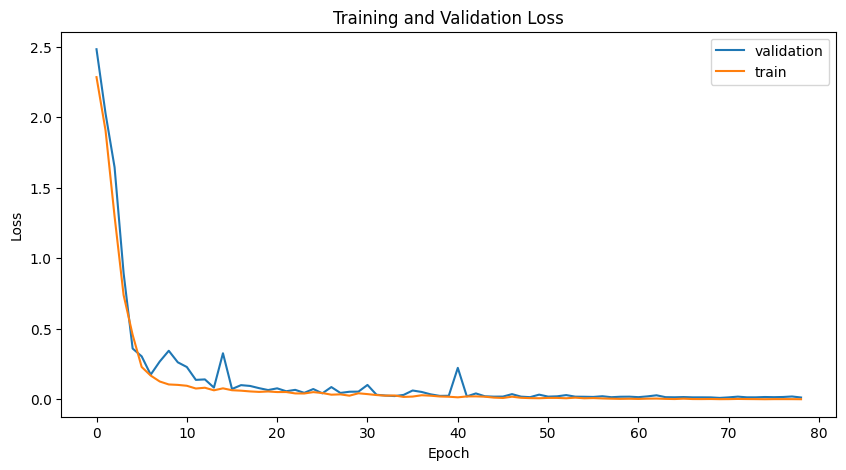

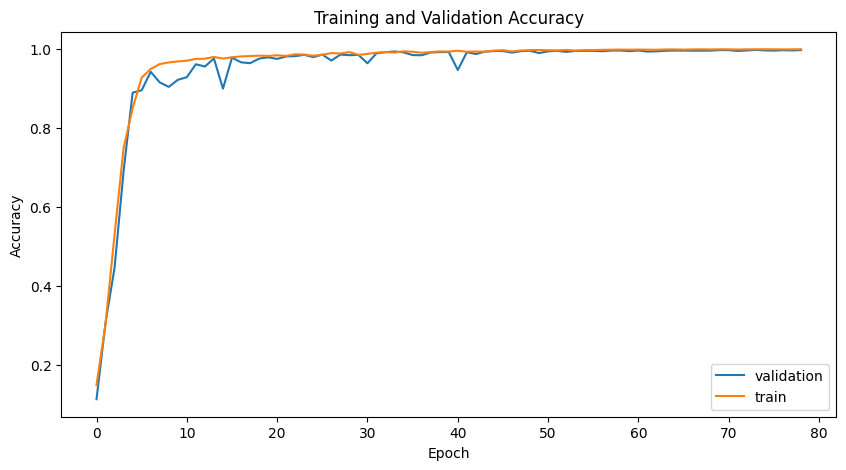

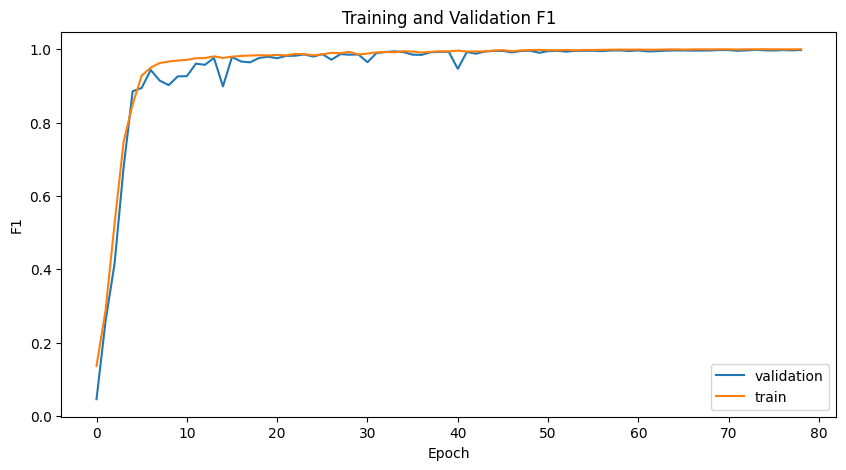

In [14]:
run_training(train_loader, val_loader, model, model_name, criterion, optimizer, config)

## Inference

In [15]:
class CNNInferenceDataset(Dataset):
    def __init__(self, images_dir, transform=None):
        super().__init__()
        self.images_dir = images_dir
        self.transform = transform

        self.images = os.listdir(images_dir)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img_name = self.images[index]
        img_path = os.path.join(self.images_dir, img_name)

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # to submit to kaggle competition I need to return image name
        return img_name, image

In [16]:
def cnn_inference(test_loader, model, model_name, config):
    model = model.to(config['DEVICE'])
    model.load_state_dict(torch.load(os.path.join(config['MODELS_DIR'], f'{model_name}_best_model.pth')))
    model.eval()
    
    df = pd.DataFrame()
    
    with torch.no_grad():
        for data in tqdm(test_loader, desc='Inference'):
            img_name, imgs = data
            imgs = imgs.to(config['DEVICE'])

            logits = model(imgs)
            probas = F.softmax(logits, dim=1)
            
            block = np.concatenate((np.array(img_name).reshape(-1, 1), probas.detach().cpu().numpy()), axis=1)
            block = pd.DataFrame(block, columns=['img', 'c0', 'c1', 'c2',
                                                 'c3', 'c4', 'c5',
                                                 'c6', 'c7', 'c8',
                                                 'c9'])
            df = pd.concat((df, block), axis=0, ignore_index=True)
    return df

In [17]:
test_transformations = val_transforms
test_dataset = CNNInferenceDataset(config['TEST_DIR'], transform=test_transformations)
test_loader = DataLoader(test_dataset, batch_size=config['BATCH_SIZE'], shuffle=False, num_workers=config['NUM_WORKERS'])

# this csv file will be submitted to kaggle
df = cnn_inference(test_loader, model, model_name, config)

Inference: 100%|██████████| 1246/1246 [05:26<00:00,  3.82it/s]


In [18]:
# resultant csv file
df.to_csv('submission.csv', index=False)